In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

## Initialization

In [31]:
# INIT
countryList_read = ['USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU']
countryList_1 = ['USA', 'CAN', 'GBR', 'FRA']
countryList_2 = countryList_1 + ['AUS', 'ITA', 'DEU', 'ESP']
countryList_trade = countryList_2

countries = CountryMetaDataFile().readMetadata()# .loc[countryList_trade] FIXME
dl = DataLib("SignalData")
dsPuller = DatastreamPulls(countries)

In [32]:
# CONSTANTS
WEEKDAYS_IN_YEAR = 261
MONTHS_IN_YEAR = 12
data_start = '1990-01'  # where rate data starts to be available for all countries
trade_start = '2000-01'  # TODO: test more time intervals
trade_end = '2020-01'
trade_period = pd.date_range(trade_start, trade_end, freq='Q')  # TODO: test more frequencies (monthly, quarterly, annually)

In [33]:
# DATA

# TODO: place in util module
def rolling_z_score(data, num_periods, min_periods):
    rolling = data.rolling(num_periods, min_periods=min_periods)
    rolling_mean = rolling.mean()
    rolling_std = rolling.std()
    return (data - rolling_mean) / rolling_std

In [34]:
LongRates = dl.pull('LongRates')# .loc[data_start:trade_end][countryList_trade] FIXME
ShortRates = dl.pull('ShortRates')#.loc[data_start:trade_end][countryList_trade]
CurveHeight = (LongRates + ShortRates)/2
CurveHeight['mean'] = CurveHeight.mean(axis=1)
for c in countryList_trade:
    CurveHeight[f'{c}_diff'] = CurveHeight[c] - CurveHeight['mean']
CurveHeight_z = rolling_z_score(CurveHeight, 5*MONTHS_IN_YEAR, 2*MONTHS_IN_YEAR)

BondReturnIndex = dl.pull('BondRetIdx/LocalFX')#.loc[data_start:trade_end][countryList_trade]
returns = BondReturnIndex.pct_change(WEEKDAYS_IN_YEAR//4).dropna(how='all')

### Approach 1 (scratched)

Divide each country's indicator by its historical max diff to world mean
- downscales each country's positions according to its historical volatility (in an oversimplified manner)
- generates less return compared to approach 2

In [35]:
Signals_1 = pd.DataFrame(index = trade_period.to_period("Q"), columns = countryList_trade + ['aggregated'])
PnLs_1 = pd.DataFrame(index = trade_period.to_period("Q"), columns = countryList_trade + ['aggregated'])

curr_date = trade_period.date[0]
for next_date in trade_period.date[1:]:
    for c in countryList_trade:
        curr_curve_height = CurveHeight[f'{c}_diff'].loc[curr_date]
        max_curve_height = CurveHeight[f'{c}_diff'].loc[data_start:curr_date].abs().max()

        signal = curr_curve_height / max_curve_height
        if signal > 1 or signal < -1:
            print(next_date)
            print(c)
            print(signal)

        Signals_1[c].loc[next_date] = signal  # intentionally placed in the next period to align with PnL

        next_return = returns[c].loc[next_date]
        pnl = signal * next_return
        PnLs_1[c].loc[next_date] = pnl

    curr_date = next_date

#### Returns

In [36]:
# EXAMINING P&L
Signals_1['aggregated'] = Signals_1.sum(axis=1)
PnLs_1['aggregated'] = PnLs_1.sum(axis=1)  # no need to ensure currency hedging since calculations are in local curr
print(str(PnLs_1.mean().sort_values(ascending=False)))
print('average quarterly return is ' + str(PnLs_1['aggregated'].mean()))

aggregated    0.005043
GBR           0.003773
CAN           0.001859
USA           0.000790
FRA          -0.001315
dtype: float64
average quarterly return is 0.005042765664347959


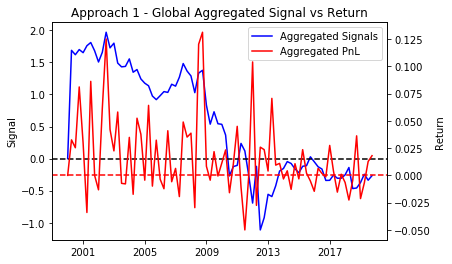

In [26]:
# global periodic return
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1, = ax1.plot(Signals_1['aggregated'].loc[trade_start:trade_end].to_timestamp(), color = 'b', label='Aggregated Signals')
ax1.axhline(y=0, color = 'k', linestyle='dashed')
ax1.set_ylabel('Signal')

l2, = ax2.plot(PnLs_1['aggregated'].loc[trade_start:trade_end].to_timestamp(), color = 'r', label='Aggregated PnL')
ax2.axhline(y=0, color = 'r', linestyle='dashed')
ax2.set_ylabel('Return')

lines = [l1, l2]
plt.legend(lines, [l.get_label() for l in lines])
plt.xlabel('Date')
plt.title(f'Approach 1 - Global Aggregated Signal vs Return')

plt.savefig('return_1_8.png')
plt.show()

In [17]:
# >1.5% loss around 2011 -> investigate
investigate_start = '2010-01'
investigate_end = '2013-01'
investigate_period = pd.date_range(investigate_start, investigate_end, freq='Q')

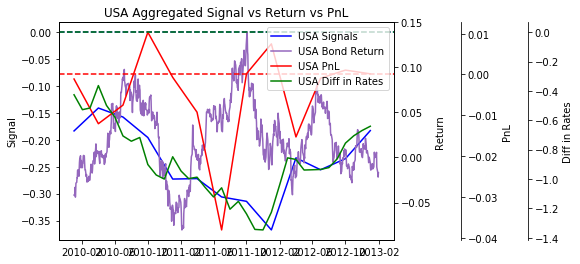

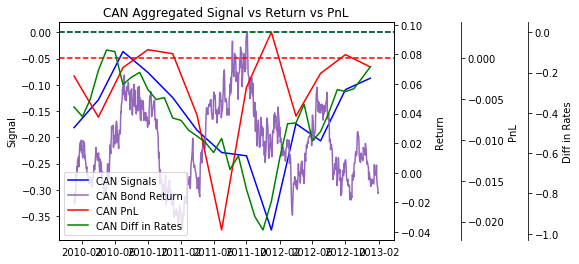

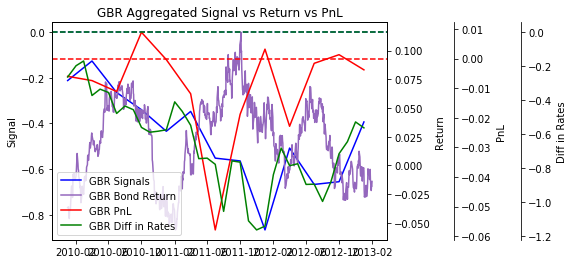

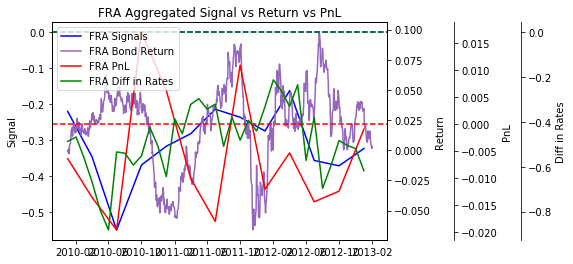

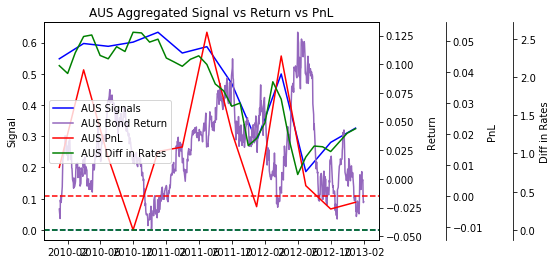

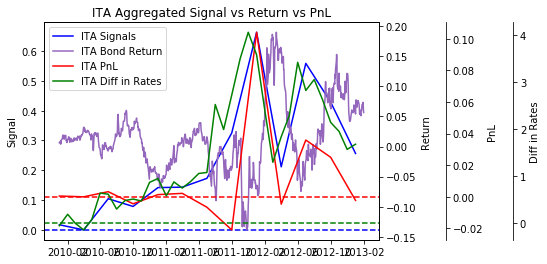

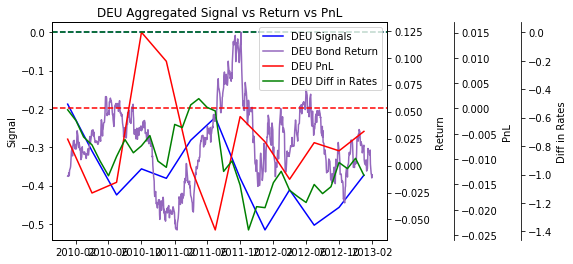

In [45]:
for c in countryList_trade:
    local_diff_rates = CurveHeight[f'{c}_diff'].loc[investigate_start:investigate_end]
    local_signals = Signals_1[c].loc[investigate_start:investigate_end]
    local_returns = returns[c].loc[investigate_start:investigate_end]
    local_pnls = PnLs_1[c].loc[investigate_start:investigate_end]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    ax4.spines["right"].set_position(("axes", 1.4))

    l1, = ax1.plot(local_signals.to_timestamp(), color = 'b', label=f'{c} Signals')
    ax1.axhline(y=0, color='b', linestyle='dashed')
    ax1.set_ylabel('Signal')

    l2, = ax2.plot(local_returns.to_timestamp(), color = 'tab:purple', label=f'{c} Bond Return')
    ax2.set_ylabel('Return')

    l3, = ax3.plot(local_pnls.to_timestamp(), color = 'r', label=f'{c} PnL')
    ax3.axhline(y=0, color='r', linestyle='dashed')
    ax3.set_ylabel('PnL')

    l4, = ax4.plot(local_diff_rates.to_timestamp(), color = 'g', label=f'{c} Diff in Rates')
    ax4.axhline(y=0, color='g', linestyle='dashed')
    ax4.set_ylabel('Diff in Rates')

    lines = [l1, l2, l3, l4]
    plt.legend(lines, [l.get_label() for l in lines])
    plt.xlabel('Date')
    plt.title(f'{c} Aggregated Signal vs Return vs PnL')

    plt.savefig(f'return_1_zoomed_{c}.png')
    plt.show()


### Approach 2

Divide each country's indicator by the current global max diff to world mean
- effectively achieves net neutral exposure to global bond market
- doesn't account for volatility

In [37]:
Signals_2 = pd.DataFrame(index = trade_period.to_period("Q"), columns = countryList_trade + ['aggregated'])
PnLs_2 = pd.DataFrame(index = trade_period.to_period("Q"), columns = countryList_trade + ['aggregated'])

curr_date = trade_period.date[0]
for next_date in trade_period.date[1:]:
    curr_curve_heights = [CurveHeight[f'{c}_diff'].loc[curr_date] for c in countryList_trade]
    max_curve_height = max([abs(ch) for ch in curr_curve_heights])

    for c in countryList_trade:
        curr_curve_height = CurveHeight[f'{c}_diff'].loc[curr_date]
        signal = curr_curve_height / max_curve_height
        Signals_2[c].loc[next_date] = signal

        next_return = returns[c].loc[next_date]
        curr_pnl = signal * next_return
        PnLs_2[c].loc[next_date] = curr_pnl

    curr_date = next_date

#### Returns

In [38]:
# EXAMINING P&L
Signals_2['aggregated'] = Signals_2.sum(axis=1)
PnLs_2['aggregated'] = PnLs_2.sum(axis=1)
# no need to ensure currency hedging since calculations are in local curr
print(str(PnLs_2.mean().sort_values(ascending=False)))
print('average quarterly return is ' + str(PnLs_2['aggregated'].mean()))

aggregated    0.012722
GBR           0.008907
CAN           0.004559
USA           0.001312
FRA          -0.001895
dtype: float64
average quarterly return is 0.012722088818900051


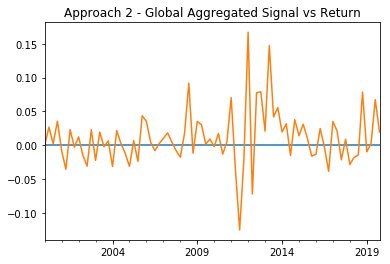

In [12]:
# global periodic return
Signals_2['aggregated'].loc[trade_start:trade_end].plot()
PnLs_2['aggregated'].loc[trade_start:trade_end].plot()  #
#plt.legend(['Signal', 'Return'])
#plt.xlabel('Date')
plt.title(f'Approach 2 - Global Aggregated Signal vs Return')
plt.savefig('return_2_8.png')
plt.show()

### 3rd approach

In [39]:
Signals_3 = pd.DataFrame(index = trade_period.to_period("Q"), columns = countryList_trade + ['aggregated'])
PnLs_3 = pd.DataFrame(index = trade_period.to_period("Q"), columns = countryList_trade + ['aggregated'])

curr_date = trade_period.date[0]
for next_date in trade_period.date[1:]:  # FIXME
    z_scores = CurveHeight_z.loc[curr_date]
    mean_z = z_scores.mean()
    max_diff = (z_scores - mean_z).abs().max()

    for c in countryList_trade:
        signal = (z_scores[c] - mean_z) / max_diff
        Signals_3[c].loc[next_date] = signal  # intentionally placed in the next period to align with PnL
        next_return = returns[c].loc[next_date]
        pnl = signal * next_return
        PnLs_3[c].loc[next_date] = pnl

    curr_date = next_date

#### Returns

In [40]:
# EXAMINING P&L
Signals_3['aggregated'] = Signals_3.sum(axis=1)
PnLs_3['aggregated'] = PnLs_3.sum(axis=1)
# no need to ensure currency hedging since calculations are in local curr
print(str(PnLs_3.mean().sort_values(ascending=False)))
print('average quarterly return is ' + str(PnLs_3['aggregated'].mean()))

USA          -0.000684
FRA          -0.000971
GBR          -0.001176
CAN          -0.001500
aggregated   -0.004276
dtype: float64
average quarterly return is -0.004276370759729021


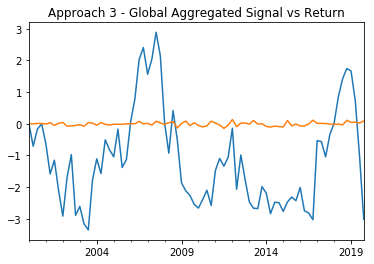

In [62]:
# global periodic return
Signals_3['aggregated'].loc[trade_start:trade_end].plot()
PnLs_3['aggregated'].loc[trade_start:trade_end].plot()  #
#plt.legend(['Signal', 'Return'])
#plt.xlabel('Date')
plt.title(f'Approach 3 - Global Aggregated Signal vs Return')

plt.savefig('return_3_8.png')
plt.show()